# Investigate Hotel Business using Data Visualization

## Import Libraries and Load Dataset

In [426]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import rcParams

pd.options.display.max_columns = None
rcParams['figure.figsize'] = (12,8)

In [427]:
plt.style.use('ggplot')

In [428]:
filepath = "hotel_bookings_data.csv"

df_raw = pd.read_csv(filepath)
df = df_raw.copy()
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_weekdays_nights,adults,children,babies,meal,city,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status
0,Resort Hotel,0,342,2017,September,27,1,0,0,2,0.0,0,Breakfast,Kota Denpasar,Direct,Direct,0,0,0,3,No Deposit,NaN,NaN,0,Personal,0.0,0,0,Check-Out
1,Resort Hotel,0,737,2017,September,27,1,0,0,2,0.0,0,Breakfast,Kota Denpasar,Direct,Direct,0,0,0,4,No Deposit,NaN,NaN,0,Personal,0.0,0,0,Check-Out
2,Resort Hotel,0,7,2017,September,27,1,0,1,1,0.0,0,Breakfast,Kabupaten Bangka,Direct,Direct,0,0,0,0,No Deposit,NaN,NaN,0,Personal,75.0,0,0,Check-Out
3,Resort Hotel,0,13,2017,September,27,1,0,1,1,0.0,0,Breakfast,Kabupaten Bangka,Corporate,Corporate,0,0,0,0,No Deposit,304.0,NaN,0,Personal,75.0,0,0,Check-Out
4,Resort Hotel,0,14,2017,September,27,1,0,2,2,0.0,0,Breakfast,Kabupaten Bangka,Online TA,TA/TO,0,0,0,0,No Deposit,240.0,NaN,0,Personal,98.0,0,1,Check-Out


## Data Cleaning

In [429]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 29 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_weekdays_nights        119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

From a quick observation, there are some binary columns categorized as numerical. There are also some float datatype that needs to be validated.

The target column is most likely **is_cancelled** column that indicates cancellation rate. Cancellations can affect overall revenue due to vacant rooms contribute to net loss for that day (source: [HotelMinder](https://www.hotelminder.com/everything-you-need-to-know-about-hotel-cancellations)). 

In [430]:
# Changing binary columns for descriptive analysis purpose
df[['is_canceled', 'is_repeated_guest']] = df[['is_canceled', 'is_repeated_guest']].astype('object')

Also, **arrival_date_week_number** appears to be redundant since the combination of **arrival_date_month** and **arrival_date_day_of_month** can tell the timing details and what week the arrival happens. However let's see the data regarding those columns.

In [431]:
df[df.arrival_date_week_number < 10].groupby(['arrival_date_week_number', 'arrival_date_month', ])[['hotel']].count()

hotel
arrival_date_week_number arrival_date_month       
1                        March                1047
2                        March                1218
3                        March                1319
4                        March                1487
5                        April                 562
                         March                 825
6                        April                1475
                         March                  33
7                        April                2109
8                        April                2216
9                        April                1416
                         May                   701

Based on the table above, it appears that the week number 1 starts with March instead of January which is a bit unusual. As mentioned before, since the combination of month and day can show what week number already, I think it's better to drop **arrival_date_week_number**.

In [432]:
df.drop('arrival_date_week_number', axis=1, inplace=True)

### Duplicated Values

In [433]:
dupes = df.duplicated().sum()
print(f'There are {dupes} rows of duplicates ({dupes * 100 / df.shape[0]:.2f}% total data)')

There are 33261 rows of duplicates (27.86% total data)


In [434]:
print(f'Total rows before dropping duplicates: {df.shape[0]}')
df.drop_duplicates(inplace=True)
print(f'Total rows after dropping duplicates: {df.shape[0]}')

Total rows before dropping duplicates: 119390
Total rows after dropping duplicates: 86129


### Missing Values

In [435]:
# Checking for columns with missing values
miss_val = {}

for col in df.columns:
    if df[col].isna().sum() > 0:
        miss_val[col] = df[col].isna().sum()

print("Columns with their sum of missing values:")
for key in miss_val:
    print(f'\t{key.ljust(10)}: {str(miss_val[key]).rjust(6)}')

print("\nColumns with their percentage of missing values:")
for key in miss_val:
    miss_percent = round(miss_val[key] / df.shape[0] * 100, 3)
    print(f'\t{key.ljust(10)}: {str(miss_percent).rjust(6)}%')

Columns with their sum of missing values:
	children  :      4
	city      :    450
	agent     :  11941
	company   :  81019

Columns with their percentage of missing values:
	children  :  0.005%
	city      :  0.522%
	agent     : 13.864%
	company   : 94.067%


Based on the numbers above, the immediate actions to take will be:
- Drop **company** column due to the amount of missing values being over 90%.
- Drop rows with missing values in **children** and **city** column due to the amount of missing values being below 1%.

In [436]:
df.drop('company', axis=1, inplace=True)
df.dropna(subset=['children', 'city'], inplace=True)

**Children** column is supposed to be int just like **adults** and **babies**.

In [437]:
# Changing children datatype
df['children'] = df['children'].astype('int64')

#### Handling 'Agent' Column

Handling **agent** column's missing values is a bit tricky because the amount of missing values is not big enough to drop the whole column and not small enough to drop the rows. For that, the missing values for **agent** will be handled by imputation.

Before imputation, I would like to check for the values for this column. 

In [438]:
print(f'Unique values in agent: {len(df.agent.unique())}\n')

print('Top 5 agents:')
t5_agent = df.agent.value_counts().head(5)
display(t5_agent)

print(f'Sum data based on top 5 agents: {t5_agent.sum()} ({t5_agent.sum() * 100 / df.shape[0]:.2f}% of data)')

Unique values in agent: 333

Top 5 agents:


9.0      28627
240.0    12922
14.0      3334
7.0       3287
250.0     2759
Name: agent, dtype: int64

Sum data based on top 5 agents: 50929 (59.44% of data)


Based on data above, there are too many unique agents to observe, so it might be a good idea to simplify the values first. To simplify the values, every values other than top 5 agents will be changed to 'Others'.

Since agent appears to be categorical labels rather than numerical, this column datatype should be changed accordingly to 'object'. 

In [439]:
# Separate top 5 agents and not top 5
t5_agent_id = t5_agent.index
t5_rem_0 = [str(i).split('.')[0] for i in t5_agent_id]
below_t5 = [i for i in df['agent'].unique() if i not in t5_agent_id]

# Change datatype to object
df['agent'] = df['agent'].astype('object')
df['agent'].replace(t5_agent_id, t5_rem_0, inplace=True)
df['agent'].replace(below_t5, 'Others', inplace=True)
df['agent'].fillna('Others', inplace=True)

df['agent'].value_counts()

Others    34746
9         28627
240       12922
14         3334
7          3287
250        2759
Name: agent, dtype: int64

### Descriptive Analysis

In [440]:
# Separate categorical and numerical columns
cats = df.select_dtypes(include='object').columns
nums = df.drop(df[cats], axis=1).columns

#### Numerical Columns

In [441]:
df[nums].describe().T

,count,mean,std,min,25%,50%,75%,max
lead_time,85675.0,79.553382,85.550228,0.00,11.00,49.0,124.0,737.0
arrival_date_year,85675.0,2018.217018,0.683854,2017.00,2018.00,2018.0,2019.0,2019.0
arrival_date_day_of_month,85675.0,15.808952,8.839799,1.00,8.00,16.0,23.0,31.0
stays_in_weekend_nights,85675.0,1.011964,1.030199,0.00,0.00,1.0,2.0,16.0
stays_in_weekdays_nights,85675.0,2.636708,2.048373,0.00,1.00,2.0,4.0,41.0
adults,85675.0,1.881331,0.626903,0.00,2.00,2.0,2.0,55.0
children,85675.0,0.140870,0.459266,0.00,0.00,0.0,0.0,10.0
babies,85675.0,0.010995,0.114420,0.00,0.00,0.0,0.0,10.0
previous_cancellations,85675.0,0.030394,0.371921,0.00,0.00,0.0,0.0,26.0
previous_bookings_not_canceled,85675.0,0.179189,1.730349,0.00,0.00,0.0,0.0,72.0


Based on descriptive analysis for numerical columns, the following columns have right skew distribution:
- **lead_time**
- **previous_bookings_not_cancelled**
- **booking_changes**
- **days_in_waiting_list**
- **adr**

There is a suspicious value in **adr** on its max at 5400.
ADR or Average Daily Rates indicates average revenue for occupied rooms in a day (source: [Investopedia](https://www.investopedia.com/terms/a/average-daily-rate.asp)). ADR alone doesn't really tell about total rooms sold, but from the dataset, it is safe to assume that each rows are 1 transactions of the same day. With that assumption, -6.38 simply denotes that one specific transaction yields a net loss, which can happen for various reasons. However, having net profit of 5400, which is over 50 times higher than mean might be a case of outlier.

#### Validating Total Guests each Bookings

The min values for **adults** and **children** are 0. While there are scenarios where 0 adult is staying, it is possible that some teenagers can book with their guardians' permissions. However, it's necessary to check for data where there is 0 adult and 0 children staying in a room.

Other than that, each room bookings should comply to total capacity regulations for safety and legal reasons. Generally, hotel rooms are designed to have up to 4 adults, or at most 6 people for suite or family type rooms (source: [Hotel Chantelle](https://hotelchantelle.com/how-many-people-can-stay-in-a-hotel-room)).

In [442]:
# Validate total guests
sus_guest_num1 = df[np.sum([df.adults, df.children], axis=0) == 0]
sus_guest_num2 = df[np.sum([df.adults, df.children, df.babies], axis=0) > 6]

sus_guest_num = pd.concat([sus_guest_num1, sus_guest_num2])
display(sus_guest_num.head())
print(f'There are {sus_guest_num.shape[0]} rows where total guests does not comply to regulations')

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_weekdays_nights,adults,children,babies,meal,city,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status
2224,Resort Hotel,0,1,2017,December,6,0,3,0,0,0,No Meal,Kota Denpasar,Corporate,Corporate,0,0,0,1,No Deposit,Others,0,Family,0.0,0,0,Check-Out
2409,Resort Hotel,0,0,2017,December,12,0,0,0,0,0,No Meal,Kota Denpasar,Corporate,Corporate,0,0,0,0,No Deposit,Others,0,Personal,0.0,0,0,Check-Out
3181,Resort Hotel,0,36,2017,January,20,1,2,0,0,0,No Meal,Kota Batu,Groups,TA/TO,0,0,0,0,No Deposit,Others,0,Family,0.0,0,0,Check-Out
3684,Resort Hotel,0,165,2017,February,30,1,4,0,0,0,No Meal,Kota Denpasar,Groups,TA/TO,0,0,0,1,No Deposit,Others,122,Family,0.0,0,0,Check-Out
3708,Resort Hotel,0,165,2017,February,30,2,4,0,0,0,No Meal,Kota Denpasar,Groups,TA/TO,0,0,0,1,No Deposit,Others,122,Family,0.0,0,0,Check-Out


There are 176 rows where total guests does not comply to regulations


In [443]:
print(f'Total rows before deleting suspicious guest sum: {df.shape[0]}')
df.drop(sus_guest_num.index, inplace=True)
print(f'Total rows after deleting suspicious guest sum: {df.shape[0]}')

Total rows before deleting suspicious guest sum: 85675
Total rows after deleting suspicious guest sum: 85499


#### Categorical Column

In [444]:
df[cats].describe().T

,count,unique,top,freq
hotel,85499,2,City Hotel,52413
is_canceled,85499,2,0,61825
arrival_date_month,85499,12,October,11110
meal,85499,5,Breakfast,66590
city,85499,177,Kota Denpasar,26787
market_segment,85499,7,Online TA,51252
distribution_channel,85499,5,TA/TO,67912
is_repeated_guest,85499,2,0,82151
deposit_type,85499,3,No Deposit,84395
agent,85499,6,Others,34622


In [445]:
print('Unique values for each columns:')
for col in cats:
    # Skip city column due to high amount of unique values
    if col == 'city':
        continue
    print(f'{col}:\n\t{df[col].unique()}\n')

Unique values for each columns:
hotel:
	['Resort Hotel' 'City Hotel']

is_canceled:
	[0 1]

arrival_date_month:
	['September' 'October' 'November' 'December' 'January' 'February' 'March'
 'April' 'May' 'June' 'July' 'August']

meal:
	['Breakfast' 'Full Board' 'Dinner' 'No Meal' 'Undefined']

market_segment:
	['Direct' 'Corporate' 'Online TA' 'Offline TA/TO' 'Complementary' 'Groups'
 'Aviation']

distribution_channel:
	['Direct' 'Corporate' 'TA/TO' 'Undefined' 'GDS']

is_repeated_guest:
	[0 1]

deposit_type:
	['No Deposit' 'Refundable' 'Non Refund']

agent:
	['Others' '240' '250' '9' '7' '14']

customer_type:
	['Personal' 'Contract' 'Family' 'Bussiness']

reservation_status:
	['Check-Out' 'Canceled' 'No-Show']



Aside from **city**, there are problematic values in **meal** and **distribution_channel** with 'Undefined'.

One other thing to nitpick will be in **market_segment** column for the value 'Complementary' should be 'Complimentary' instead, which means 'free services (including rooms) as a show of good-will' in hotel industry (source: [hotelmanagement.net](https://www.hotelmanagement.net/operate/hotels-give-to-receive-analysis-complimentary-services-and-rooms)).

In [446]:
df['market_segment'].replace('Complementary', 'Complimentary', inplace=True)

Let's take a look at the values in **meal** and **distribution_channel**

In [447]:
val_check_col = ['meal', 'distribution_channel']
for col in val_check_col:
    print(f'{col}:\n{df[col].value_counts()}\n')

meal:
Breakfast     66590
No Meal        9351
Dinner         8761
Undefined       450
Full Board      347
Name: meal, dtype: int64

distribution_channel:
TA/TO        67912
Direct       12649
Corporate     4759
GDS            178
Undefined        1
Name: distribution_channel, dtype: int64



For **meal**, the value 'Undefined' might actually be 'Lunch' to complete the 3 major type of meals without affecting other values.

For **distribution_channel**, there is only 1 'Undefined' value, so to avoid giving unecessary bias towards other value, it's better to drop it.

In [448]:
# Changing undefined to lunch
df['meal'].replace('Undefined', 'Lunch', inplace=True)

# Dropping undefined in distribution channel
undef_channel = df[df.distribution_channel == 'Undefined']
df.drop(undef_channel.index, inplace=True)

### Handling Outliers

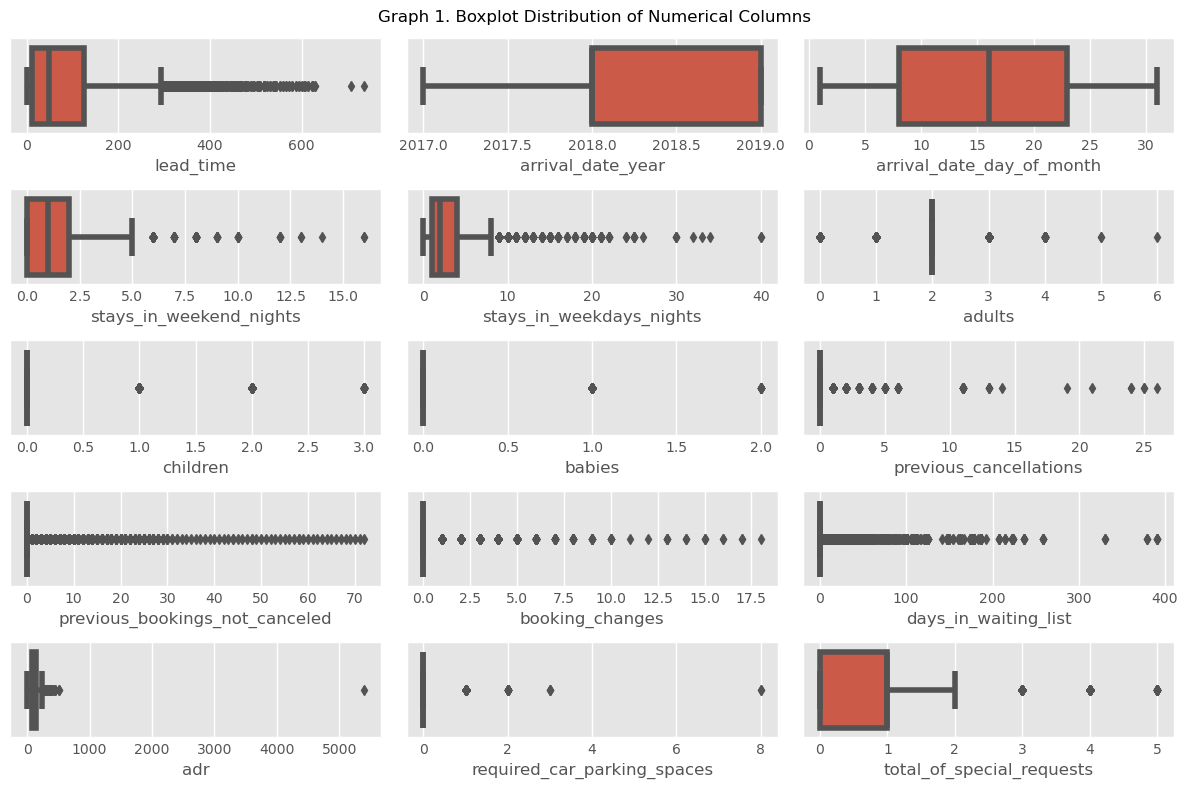

In [449]:
plt.suptitle('Graph 1. Boxplot Distribution of Numerical Columns')
for i, col in enumerate(nums):
    plt.subplot(5, 3, i+1)
    sns.boxplot(x=df[col])
plt.tight_layout()

From graph 1. above, every numerical columns have outliers based on IQR except for **arrival_date_year** and **arrival_date_dat_of_month**. However, most of those outliers are valid and important values, for example stay duration both on weekend and weekdays. Even **lead_time** of over 600 days can be considered valid, despite being a very rare occasion depending on hotel's booking policy (source: [AwardWallet](https://awardwallet.com/blog/far-advance-can-book-hotel-reservations)).

That being said, there are some questionable outliers in the following columns:
- **ADR**: as mentioned before, the value 5400 might be caused by an imputation error
- **Required_car_parking_spaces**: the average parking space per room in America is 1.21 ([STR](https://str.com/data-insights-blog/definitive-guide-hotel-parking-counts)), having requirement of 8 parking space for 1 booking seems to be unusual

Let's take a look at the data regarding those outliers manually.

In [450]:
# Make small dataframes manually for outliers mentioned above
outlier1 = df[df.adr > 5000]
outlier2 = df[df.required_car_parking_spaces > 6]

df_outlier = pd.concat([outlier1, outlier2])
df_outlier[['is_canceled', 'is_repeated_guest', 'adults', 'children', 'babies', 'adr', 'required_car_parking_spaces', 'reservation_status']]

,is_canceled,is_repeated_guest,adults,children,babies,adr,required_car_parking_spaces,reservation_status
48515,1,0,2,0,0,5400.0,0,Canceled
29045,0,1,2,0,0,40.0,8,Check-Out
29046,0,1,2,0,0,80.0,8,Check-Out


It might be better to drop these datas

In [451]:
df.drop(df_outlier.index, inplace=True)